In [2]:
#Imoprts:
import pandas as pd
from datetime import timedelta
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
#Reading in data
df = pd.read_csv('./Datasets/cleaned_df.csv')

In [4]:
# Change date column to be datetime dtype
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)



# Testing for Stationarity

---

In [6]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

# Run ADF test on original (non-differenced!) data.
#adfuller(df['aqi'])

In [7]:
type(df.county_name.unique().tolist())

list

In [8]:
my_dict = {"County":[],"T-stat":[],"P-Value":[]};
for i in df.county_name.unique().tolist():
    mask=df[df['county_name']== i]
    t = adfuller(mask['aqi'])
    p = adfuller(mask['aqi'])
    my_dict["County"].append(i)
    my_dict["T-stat"].append(t[0:1])
    my_dict["P-Value"].append(p[1:2])

In [9]:
#my_dict

In [10]:
stationality = pd.DataFrame(my_dict) 

In [11]:
# displaying the scores 
stationality.style 

,County,T-stat,P-Value
0,Fresno,"(-7.902655318187861,)","(4.1453186773950825e-12,)"
1,Mendocino,"(-8.988391489956756,)","(6.999189738569047e-15,)"
2,Mono,"(-60.019669742188,)","(0.0,)"
3,Inyo,"(-16.186964061995734,)","(4.209132678832455e-29,)"
4,Orange,"(-18.29449131822816,)","(2.293574893022505e-30,)"
5,Glenn,"(-16.65028546330898,)","(1.6062512633519064e-29,)"
6,Napa,"(-14.129971946847451,)","(2.3430321136052552e-26,)"
7,Kings,"(-8.036857680053531,)","(1.8925268857358217e-12,)"
8,Stanislaus,"(-8.823737640983616,)","(1.8474008730706076e-14,)"
9,Ventura,"(-9.659056772888473,)","(1.3690539739720566e-16,)"


# Los Angeles Trending

In [12]:
la = pd.DataFrame(df[df['county_name']== 'Los Angeles'])

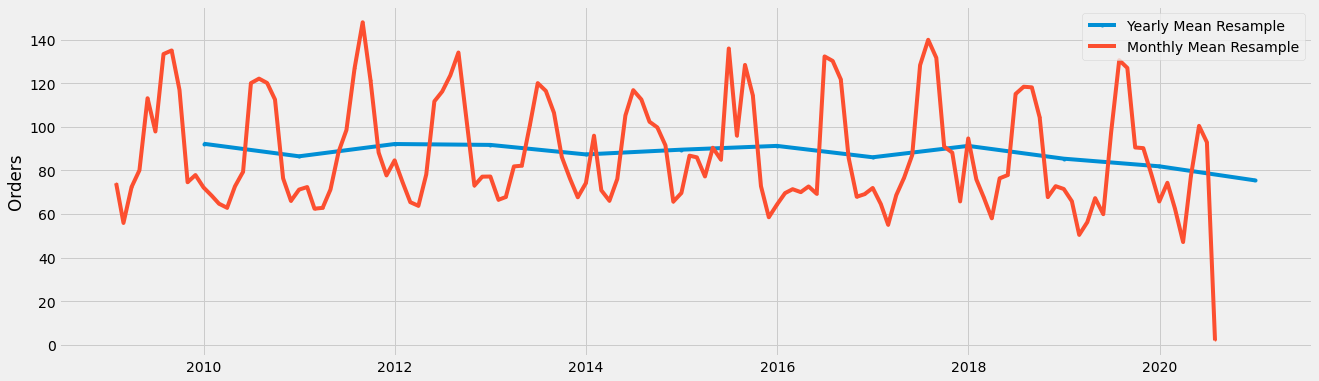

In [13]:
import warnings
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
y = la['aqi']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y.resample('Y').mean(),marker='o', markersize=3, linestyle='-', label='Yearly Mean Resample')
ax.plot(y.resample('M').mean(),marker='o', markersize=1, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

Then we can look at the basic up/down patterns, overall trend, anomalies, and generally get a sense of what kind of data we’re dealing with. This is just a gut check of the data without going too deep. If there are any very strange anomalies, we might reach out to a subject matter expert to understand possible causes. We are also looking here for any red flags like missing data or other obvious quality issues.

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# graphs to show seasonal_decompose
def seasons(y, n):
    decomposition = seasonal_decompose(y, freq=n)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

<ipython-input-14-5b720d689dc9>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=n)


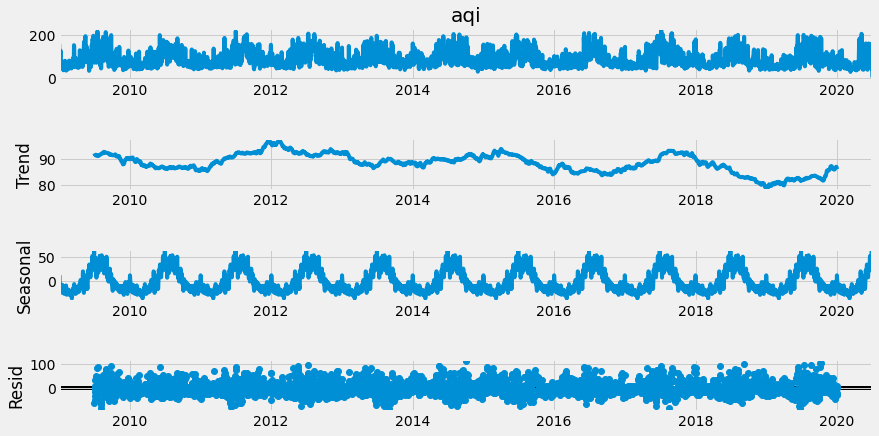

In [15]:
#Year seasonality for LA
seasons(y, 365)

<ipython-input-14-5b720d689dc9>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=n)


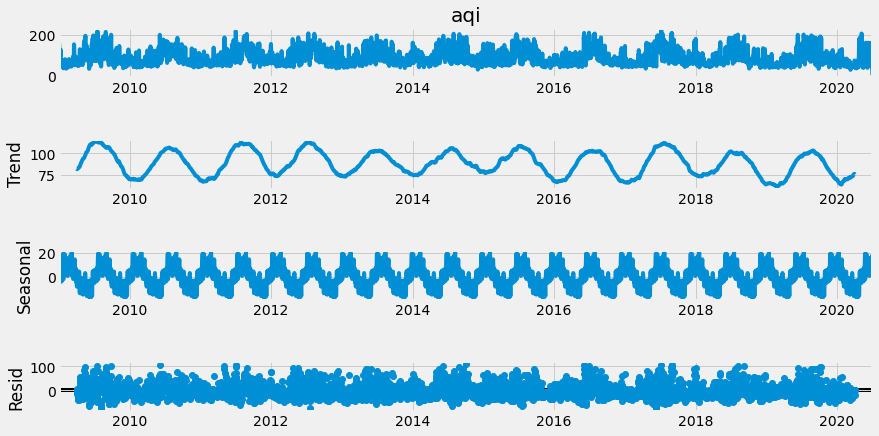

In [16]:
#half a year seasonality in Los Angeles
seasons(y, 180)

<ipython-input-14-5b720d689dc9>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=n)


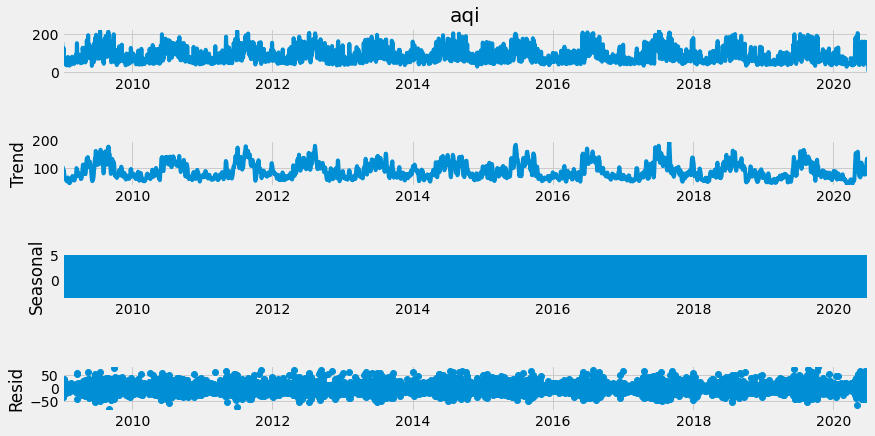

In [17]:
seasons(y, 7)

<ipython-input-14-5b720d689dc9>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=n)


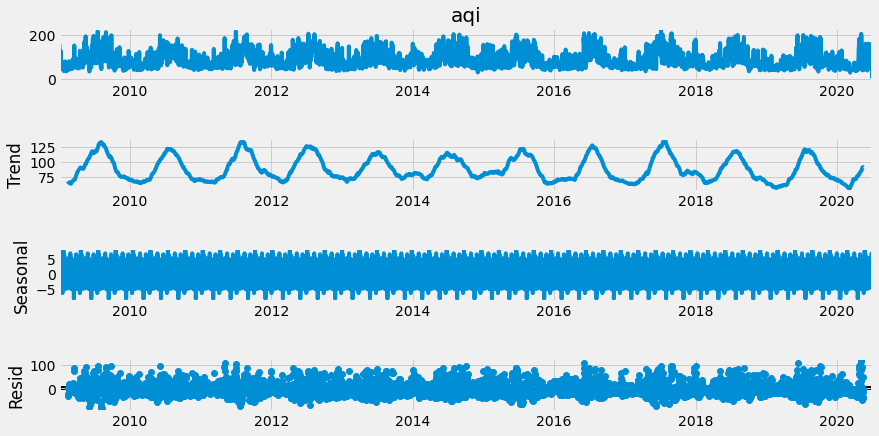

In [18]:
seasons(y, 90)

# Stationarity for LA

In [19]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

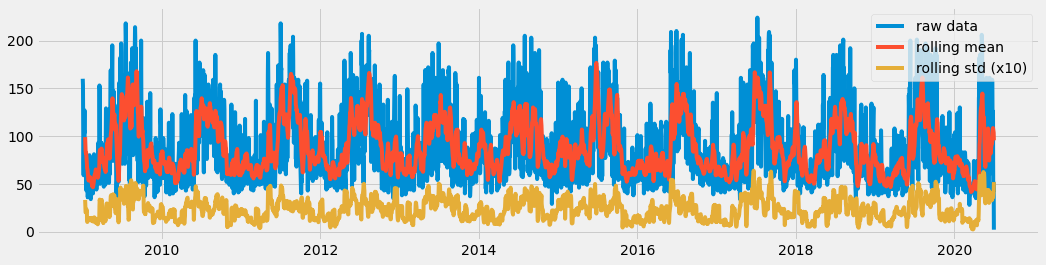

In [20]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

Both the mean and standard deviation for stationary data does not change much over time. But in this case, since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph. Therefore, we should do another test of stationarity.



In [21]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [22]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -6.569
P-value = 0.000
Critical values :
	1%: -3.4319157624548438 - The data is  stationary with 99% confidence
	5%: -2.8622318677802716 - The data is  stationary with 95% confidence
	10%: -2.5671382871908053 - The data is  stationary with 90% confidence


# Making Data Stationary

In [23]:
# Detrending
#y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

#test_stationarity(y_detrend,'de-trended data')
#ADF_test(y_detrend,'de-trended data')

# Differencing
#y_12lag =  y - y.shift(12)

#test_stationarity(y_12lag,'12 lag differenced data')
#ADF_test(y_12lag,'12 lag differenced data')

# Detrending + Differencing

#y_12lag_detrend =  y_detrend - y_detrend.shift(12)

#test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
#ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

# Create Training & Testing Datasets

In [25]:
#y = y.resample('w').mean()

# Baseline SARIMA Model
---

In [26]:
y

date
2009-01-01    160
2009-01-02    153
2009-01-03    101
2009-01-04     72
2009-01-05     59
             ... 
2020-06-27    119
2020-06-28     42
2020-06-29     44
2020-06-30     51
2020-07-01      2
Name: aqi, Length: 4200, dtype: int64

In [24]:
#defining training and testing set

#Training dates
y_to_train = y['2010-01-01':'2018-12-31'] 

#testing dates
y_to_val = y['2019-01-01':'2019-12-31']

#Number of Data Points for the test
predict_date = len(y) - len(y['2019-01-01':'2019-12-31'])

In [26]:
#runing Sarima model with p, d, q as 0, 0, 0, respectively as a baseline SARIMA model
sarima = sm.tsa.statespace.SARIMAX(endog = y_to_train,
                                   order = (0, 0, 0),
                                   #s is set to 365 for seasoality
                                   seasonal_order = (1,0,1, 365)).fit()
sarima_pred = sarima.predict(start=y_to_val.index[0], end=y_to_val.index[-1])

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [27]:
#AIC score for SARIMA baseline model
sarima.aic

33155.47291268068

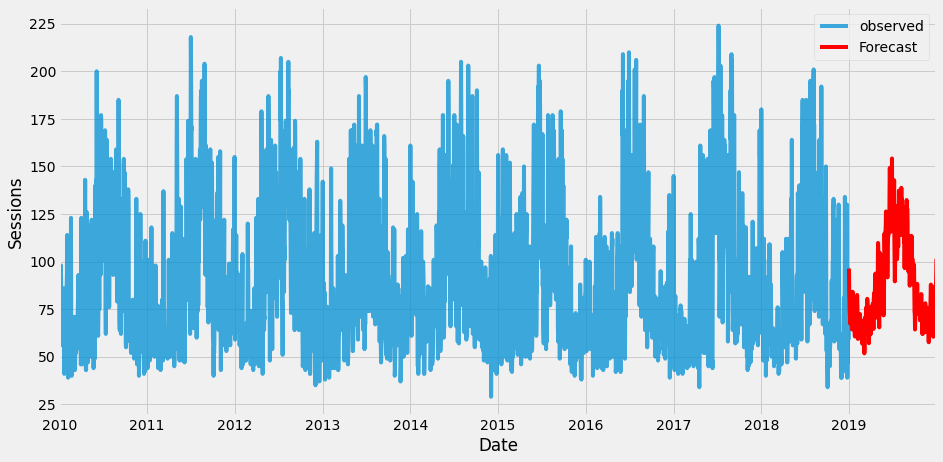

In [33]:
ax = y_to_train.plot(label='observed', alpha=0.75)
sarima_pred.to_frame(name='Forecast').plot(ax=ax, label='Dynamic Forecast', figsize=(14, 7), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
#plt.title(f'Dynamic Forecast for {county}')
plt.legend()
plt.show()

In [34]:
from sklearn import metrics
# generate predictions off the model
#pred = ar.predict(dynamic=True, start=test.index[0], end=test.index[-1])
    # calculate RMSE and show the score 
rmse = metrics.mean_squared_error(y_to_val, sarima_pred, squared=False)
rmse

31.926994950329874

In [35]:
def rmse_ma(true_val, pred, n):
    return (sum((true_val[:n] - pred[:n]) ** 2)/n)**(1/2)

In [40]:
rmse_ma(y_to_val, sarima_pred, 7)

17.094818672772355

# SARIMA MODEL test 2 

In [ ]:
#runing Sarima model with p, d, q as 0, 0, 0, respectively as a baseline SARIMA model
sarima_1 = sm.tsa.statespace.SARIMAX(endog = y_to_train,
                                   order = (0, 0, 0),
                                   #s is set to 365 for seasoality
                                   seasonal_order = (2,0,2, 365)).fit()
sarima_pred = sarima.predict(start=y_to_val.index[0], end=y_to_val.index[-1])

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


# GridSearch for SARIMA Model

---

In [24]:
import itertools
def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0,2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in pdq]
    mini = float('+inf')
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
#sarima_grid_search(y_to_train,365)

In [125]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2026      0.046      4.424      0.000       0.113       0.292
ma.L1         -1.0079      0.013    -80.562      0.000      -1.032      -0.983
ma.S.L52      -1.0001    109.985     -0.009      0.993    -216.566     214.566
sigma2       359.3465   3.95e+04      0.009      0.993   -7.71e+04    7.78e+04


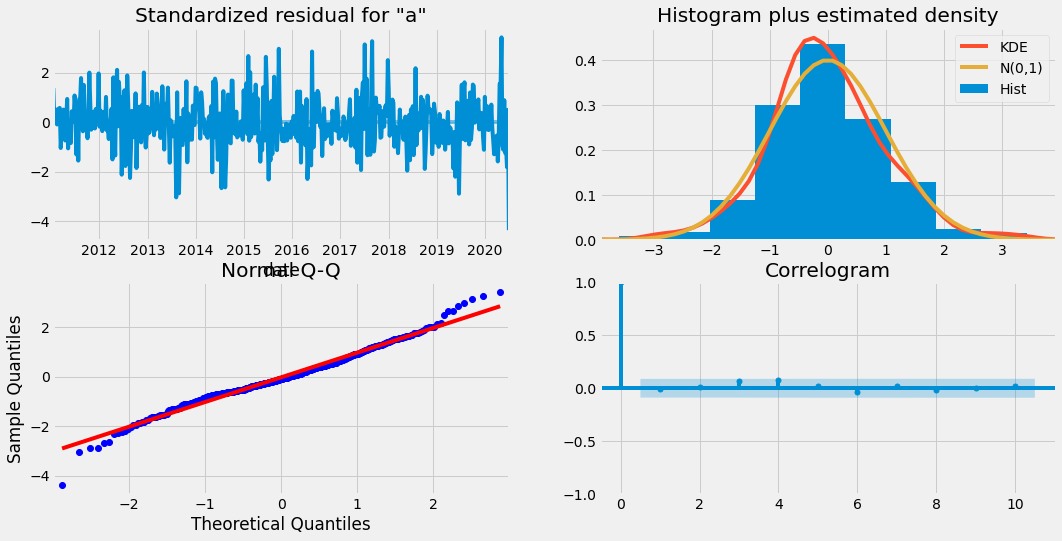

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 36.95


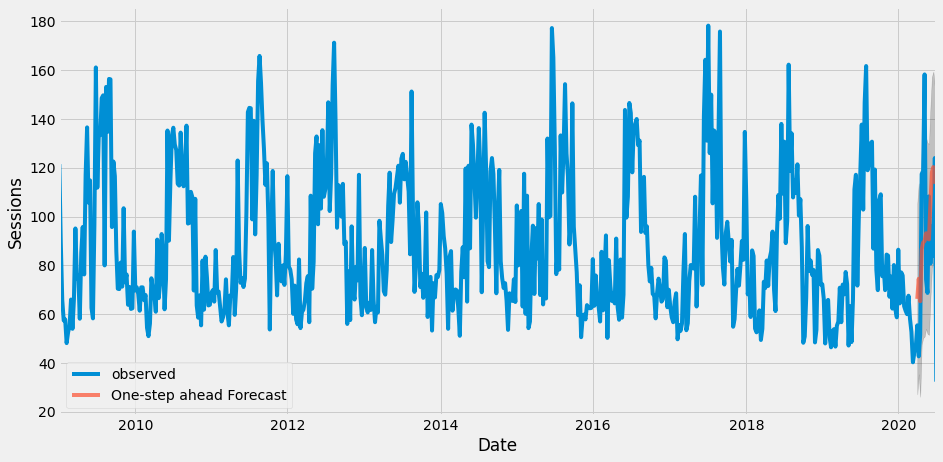

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 38.24


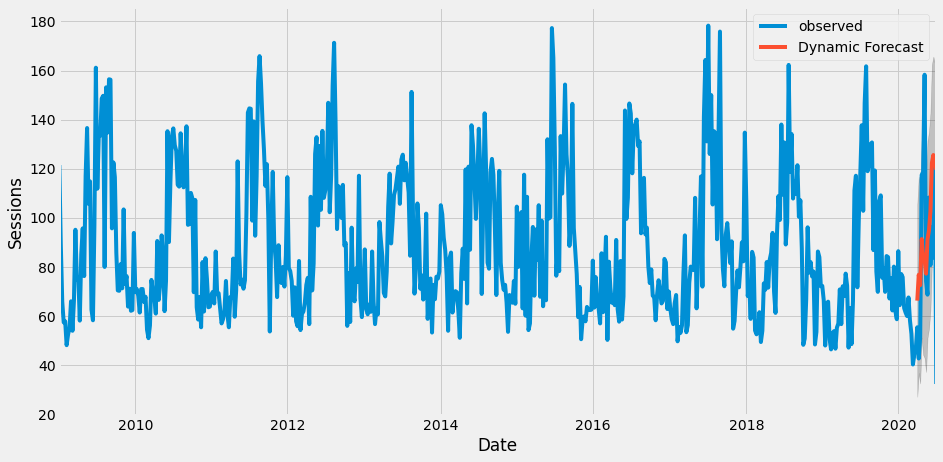

In [127]:
import numpy as np
model = sarima_eva(y,(1, 1, 1),(0, 1, 1, 52),52,'2020-04-05',y_to_val)

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

By validating all the four points above, we can conclude that this model’s residuals are near normally distributed. This indicates we have found a well-fit model suitable for our dataset.

If we were only concerned with achieving the lowest Root Mean Squared Error, we would choose the Simple Exponential Smoothing (SES) model to use since it produced the smallest error. In many business cases where longer-term forecasting with more nuanced visualizations are needed in our overall analysis, the SARIMA model is preferred. 



In [128]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)


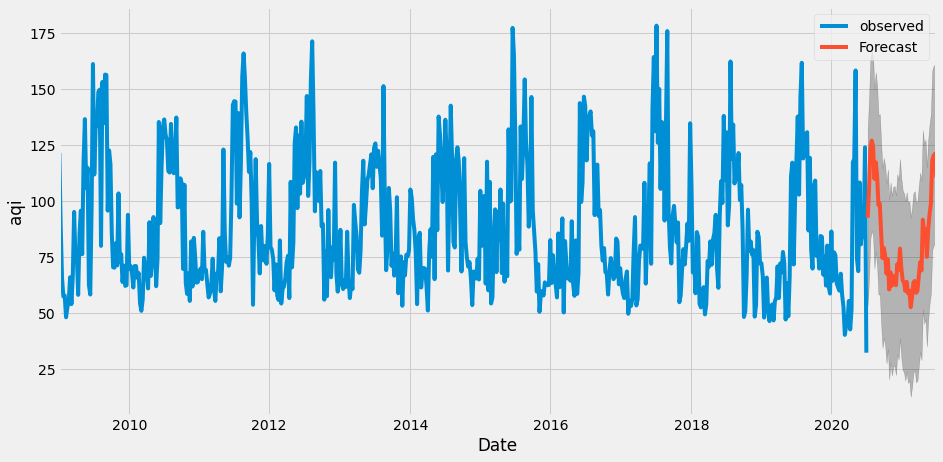

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-07-12,92.53748445,53.40309753,131.67187137
1,2020-07-19,105.50743370,65.50815536,145.50671204
2,2020-07-26,123.32098638,83.27103751,163.37093524
3,2020-08-02,126.96896793,86.91237356,167.02556230
4,2020-08-09,124.44801997,84.38881544,164.50722451


In [129]:
final_table = forecast(model,52,y)
final_table.head()

The green line in the graph represents the expected future data based on the forecasting model we built. The green line represents the average forecasted value for each week, and we would not be surprised to see the actual numbers track to this line for the most part. But there is no guarantee of this!

The gray area above and below the green line represents the 95 percent confidence interval and as with virtually all forecasting models, as the predictions go further into the future, the less confidence we have in our values. In this case, we are 95 percent confident that the actual sales will fall inside this range. But, there is a chance the actuals could fall completely outside this range also. The larger the future time period for which we want to predict, the larger this confidence range will be (that is, the less precise our forecast is).

# Graph of only Predicted Weeks

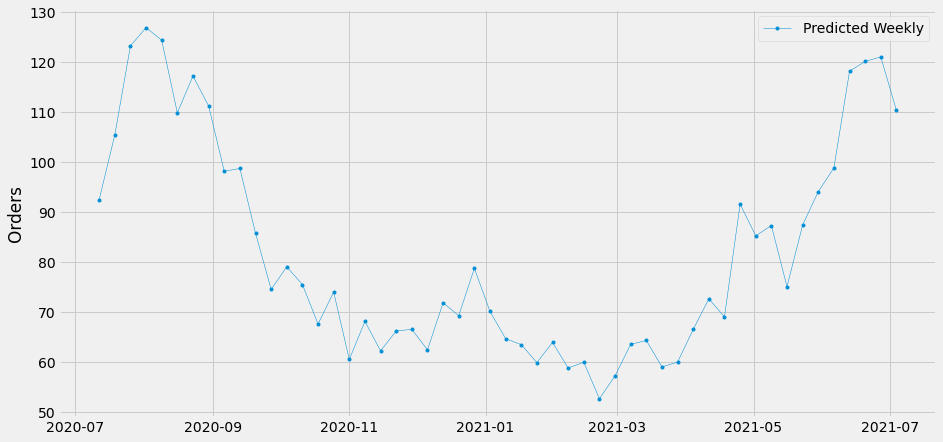

In [133]:

### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
#ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();